In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
os.listdir('/kaggle/input/dogs-vs-cats/')

['test1.zip', 'train.zip', 'sampleSubmission.csv']

***Extracting all the zipped files***

In [3]:
import zipfile

with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip') as zipp:
    zipp.extractall('.')
    print('Finished extracting train.zip')
    zipp.close()

with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip') as zipp:
    zipp.extractall('.')
    print('Finished extracting test1.zip')
    zipp.close()

Finished extracting train.zip
Finished extracting test1.zip


In [4]:
print('Number of images in train directory:', len(os.listdir('/kaggle/working/train/')))
print('Number of images in test directory:', len(os.listdir('/kaggle/working/test1/')))
print('Some files from the train directory:')
print(os.listdir('/kaggle/working/train/')[:10])

Number of images in train directory: 25000
Number of images in test directory: 12500
Some files from the train directory:
['cat.10600.jpg', 'cat.11492.jpg', 'cat.3946.jpg', 'cat.8568.jpg', 'dog.5166.jpg', 'dog.7371.jpg', 'dog.4927.jpg', 'cat.408.jpg', 'cat.11311.jpg', 'dog.4365.jpg']


***Building the dataset as Dataframe***

In [5]:
train_images_path = []
train_labels = []
all_files = os.listdir('/kaggle/working/train/')

for file in all_files:
    label = file.split('.')[0]
    file_path = os.path.join('/kaggle/working/train/', file)
    train_images_path.append(file_path)
    train_labels.append(label)

In [6]:
test_images_path = []
test_labels = []
all_test_files = os.listdir('/kaggle/working/test1/')

for file in all_test_files:
    label = file.split('.')[0]
    file_path = os.path.join('/kaggle/working/test1/', file)
    test_images_path.append(file_path)
    test_labels.append(label)

In [7]:
print('Printing random record from train_images list:')
print(train_images_path[10])
print(train_labels[10])

Printing random record from train_images list:
/kaggle/working/train/dog.99.jpg
dog


In [8]:
print('Printing random record from test_images list:')
print(test_images_path[10])
print(test_labels[10])

Printing random record from test_images list:
/kaggle/working/test1/4518.jpg
4518


In [10]:
import pandas as pd

In [11]:
dataframe = pd.DataFrame()
dataframe['images'] = train_images_path
dataframe['label'] = train_labels

In [12]:
print('First 10 records of dataframe.')
dataframe.head(10)

First 10 records of dataframe.


,images,label
0,/kaggle/working/train/cat.10600.jpg,cat
1,/kaggle/working/train/cat.11492.jpg,cat
2,/kaggle/working/train/cat.3946.jpg,cat
3,/kaggle/working/train/cat.8568.jpg,cat
4,/kaggle/working/train/dog.5166.jpg,dog
5,/kaggle/working/train/dog.7371.jpg,dog
6,/kaggle/working/train/dog.4927.jpg,dog
7,/kaggle/working/train/cat.408.jpg,cat
8,/kaggle/working/train/cat.11311.jpg,cat
9,/kaggle/working/train/dog.4365.jpg,dog


In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt

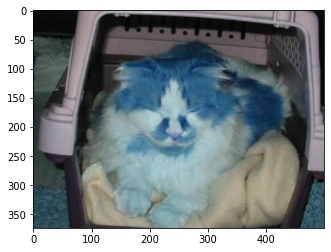

In [14]:
import cv2
img = cv2.imread(train_images_path[8090])
plt.imshow(img, cmap='binary')
plt.show()

In [15]:
train_labels[8090]

'cat'

***Creating generator***

In [72]:
only_train = dataframe.loc[1:20000, :]
only_validation = dataframe.loc[20000:25000, :]

In [81]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           horizontal_flip = True,
                                                           zoom_range=0.2)
tg = train_gen.flow_from_dataframe(dataframe=only_train,
                              x_col = 'images',
                              y_col = 'label',
                              target_size = (150, 150),
                              batch_size = 150,
                             class_mode='binary')


validation_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           horizontal_flip = True,
                                                           zoom_range=0.2)
vg = validation_gen.flow_from_dataframe(dataframe=only_validation,
                              x_col = 'images',
                              y_col = 'label',
                              target_size = (150, 150),
                              batch_size = 150,
                                  class_mode='binary')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


***Defining network & training the network***

In [74]:
def network():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)))
    model.add(tf.keras.layers.MaxPooling2D(2,2))
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(2,2))
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(2,2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

In [82]:
my_model = network()

result = my_model.fit(tg,
            epochs = 40,
            steps_per_epoch = (only_train.shape[0]//150),
                      validation_data = vg,
            validation_steps = (only_validation.shape[0]//150))

2022-05-25 11:55:01.305455: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-05-25 11:55:04.361379: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


133/133 [==============================] - 200s 1s/step - loss: 0.6417 - accuracy: 0.6180 - val_loss: 0.5671 - val_accuracy: 0.7075
Epoch 2/40
133/133 [==============================] - 193s 1s/step - loss: 0.5172 - accuracy: 0.7424 - val_loss: 0.4757 - val_accuracy: 0.7719
Epoch 3/40
133/133 [==============================] - 193s 1s/step - loss: 0.4644 - accuracy: 0.7745 - val_loss: 0.4418 - val_accuracy: 0.7905
Epoch 4/40
133/133 [==============================] - 193s 1s/step - loss: 0.4189 - accuracy: 0.8062 - val_loss: 0.4294 - val_accuracy: 0.7962
Epoch 5/40
133/133 [==============================] - 194s 1s/step - loss: 0.4034 - accuracy: 0.8139 - val_loss: 0.4017 - val_accuracy: 0.8172
Epoch 6/40
133/133 [==============================] - 194s 1s/step - loss: 0.3816 - accuracy: 0.8285 - val_loss: 0.3911 - val_accuracy: 0.8200
Epoch 7/40
133/133 [==============================] - 192s 1s/step - loss: 0.3641 - accuracy: 0.8381 - val_loss: 0.4599 - val_accuracy: 0.7889
Epoch 8/40

***Result shows that the network gets overfitted after 14th iteration***

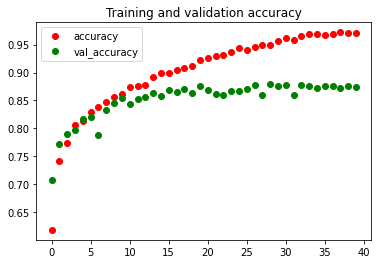

In [90]:
accuracy = result.history['accuracy']
validation_acc = result.history['val_accuracy']

epoks = range(0, len(result.history['accuracy']))

plt.plot(epoks, accuracy, 'ro', label='accuracy')
plt.plot(epoks, validation_acc, 'go', label='val_accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

***Setting a early stopping mechanism which stops the training when network starts to overfit***

In [ ]:
my_model = network()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                mode='min',
                                patience=3,
                                verbose=0)
result = my_model.fit(tg,
            epochs = 40,
            steps_per_epoch = (only_train.shape[0]//150),
                      validation_data = vg,
            validation_steps = (only_validation.shape[0]//150),
                     callbacks=[early_stopping])